In [16]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
from scipy.linalg import svd, expm
import time

In [26]:
# Define functions

def syssim(M, N, dim_lat, nu):
    Z = np.zeros((dim_lat + nu, N))
    rho = 5  # Increasing rho increases excitation for better operator recovery
    Sigma = rho * np.eye(dim_lat + nu) + np.random.rand(dim_lat + nu, dim_lat + nu)
    Sigma_symm = ((1 / 2) * (Sigma + Sigma.T))
    Sigma_symm = ((dim_lat + nu) / np.trace(Sigma_symm)) * Sigma_symm

    for i in range(N):
        Z[:, i] = sqrtm(Sigma_symm).dot(np.random.normal(0, 1, dim_lat + nu))

    w = np.random.normal(0, 1, dim_lat)
    Y = M.dot(Z) + w.reshape(-1, 1)

    return Z, Y


def subspace_distance(Phi_1, Phi_2):
    r = Phi_1.shape[0]
    distance = np.sqrt(r - np.linalg.norm(Phi_1.dot(Phi_2.T), 'fro') ** 2)
    return distance


def tasksgen(nx, nu, r, dim_lat, H, scale):
    # True representation
    Phi, _, _ = svd(np.random.randn(dim_lat + nu, dim_lat + nu))
    Phi = Phi[:r, :]

    F_0 = np.random.randn(dim_lat, nu + nx)  # Nominal task weights F
    M_0 = F_0.dot(Phi)  # Nominal operator M

    # Generating different tasks weights
    F = []
    P = []
    for h in range(1, H + 1):
        L = scale * np.random.randn(dim_lat, dim_lat)
        skewL = (L - L.T) / 2
        P.append(expm(skewL))
        F.append(P[h - 1].dot(F_0))  # Generating the true weights for H different tasks

    M = []
    for h in range(H):
        M.append(F[h].dot(Phi))  # Generating the true operators M for H different tasks
    return M, Phi

def feature_whitened_alt_descent(Phi_hat, K, eta, H, M, Phi_true, nx, nu, N, dim_lat):
    F = [np.zeros((nx + nu, dim_lat + nu)) for _ in range(H)]
    Phi = [Phi_hat.copy() for _ in range(H)]
    Error_rep = np.zeros(K)

    for k in range(K):
        start_time = time.time()
        # Calculating subspace distance
        Error_rep[k] = subspace_distance(Phi_true, Phi_hat)
        

        # Initializing all the tasks with the same representation
        for h in range(H):
            Phi[h] = Phi_hat.copy()

        for h in range(H):
            # Sample a fresh data-set
            Z1, Y1 = syssim(M[h], N, dim_lat, nu)
            Z2, _ = syssim(M[h], N, dim_lat, nu)
            Z3, Y3 = syssim(M[h], N, dim_lat, nu)

            cov_sum = Z2.dot(Z2.T)

            # Computing Grad_Phi
            inv_term = np.linalg.inv(Phi[h].dot(Z1.dot(Z1.T)).dot(Phi[h].T))
            F[h] = Y1.dot(Z1.T).dot(Phi[h].T).dot(inv_term)
            Grad_Phi = (F[h].T.dot(F[h]).dot(Phi[h]).dot(Z3.dot(Z3.T)) - F[h].T.dot(Y3).dot(Z3.T)).dot(np.linalg.inv(cov_sum))
            Phi[h] -= eta * Grad_Phi

        # Aggregation
        Phi_avg = np.zeros((nx + nu, dim_lat + nu))
        for h in range(H):
            Phi_avg += (1 / H) * Phi[h]

        Q,R = np.linalg.qr(Phi_avg.T, mode='reduced')
        Phi_hat = Q.T
        
        end_time = time.time()
        print(f"Iteration: {k}, Error: {Error_rep[k]}, Time: {end_time - start_time}")
        
    return Error_rep


def alt_descent(Phi_hat, K, eta, H, M, Phi_true, nx, nu, N, dim_lat):
    F = [np.zeros((nx + nu, dim_lat + nu)) for _ in range(H)]
    Phi = [Phi_hat.copy() for _ in range(H)]
    Error_rep = np.zeros(K)

    for k in range(K):
        start_time = time.time()
        # Calculating subspace distance
        Error_rep[k] = subspace_distance(Phi_true, Phi_hat)

        # Initializing all the tasks with the same representation
        for h in range(H):
            Phi[h] = Phi_hat.copy()

        for h in range(H):
            # Sample a fresh data-set
            Z, Y = syssim(M[h], N, dim_lat, nu)

            # Computing F and Grad_Phi
            inv_term = np.linalg.inv(Phi[h].dot(Z.dot(Z.T)).dot(Phi[h].T))
            F[h] = Y.dot(Z.T).dot(Phi[h].T).dot(inv_term)
            Grad_Phi = (F[h].T.dot(F[h]).dot(Phi[h]).dot(Z.dot(Z.T)) - F[h].T.dot(Y).dot(Z.T))

            Phi[h] -= eta * Grad_Phi

        # Aggregation
        Phi_avg = np.zeros((nx + nu, dim_lat + nu))
        for h in range(H):
            Phi_avg += (1 / H) * Phi[h]

        Q,R = np.linalg.qr(Phi_avg.T, mode='reduced')
        Phi_hat = Q.T
        end_time = time.time()
        print(f"Iteration: {k}, Error: {Error_rep[k]}, Time: {end_time - start_time}")
    return Error_rep

$\textbf{System Parameter:}$

In [24]:
# System dimensions
nx = 5
nu = 2
r = nx + nu  # rank
dim_lat = 50  # dimension of the latent space
H = 10  # number of tasks
scale = 0.001  # scale of rotation

M, Phi_true = tasksgen(nx, nu, r, dim_lat, H, scale)

np.save('seed', {"M_list": M, "Phi_true": Phi_true})

nr = 1  # Number of systems realizations
K = 30  # number of global iterations
Error_r = []
N = 100  # number of samples

eta = 0.0075  # step-size

$\textbf{De-biasing and Feature Whitening:}$

In [25]:
L = np.random.randn(dim_lat + nu, dim_lat + nu)
skewL = (L - L.T) / 2
rot = expm(skewL)
Phi_hat = Phi_true.dot(rot)
Error_FW = feature_whitened_alt_descent(Phi_hat, K, eta, H, M, Phi_true, nx, nu, N, dim_lat)

Iteration: 0, Error: 2.4780924265370072, Time: 3.445944309234619
Iteration: 1, Error: 2.2105121967221146, Time: 3.5628345012664795
Iteration: 2, Error: 1.9090084875815476, Time: 3.333808183670044
Iteration: 3, Error: 1.7121202596068315, Time: 3.3790082931518555
Iteration: 4, Error: 1.538975368563666, Time: 3.355320453643799
Iteration: 5, Error: 1.407618395932332, Time: 3.405214786529541
Iteration: 6, Error: 1.2523732622581247, Time: 3.482457399368286
Iteration: 7, Error: 1.1134467898575218, Time: 3.4246137142181396
Iteration: 8, Error: 1.0091644116394507, Time: 3.659019708633423
Iteration: 9, Error: 0.9457868238468772, Time: 3.428593158721924
Iteration: 10, Error: 0.8656201620575994, Time: 3.537102222442627
Iteration: 11, Error: 0.7603158175737662, Time: 3.6031653881073
Iteration: 12, Error: 0.635132786610243, Time: 3.2539775371551514
Iteration: 13, Error: 0.4846822072924698, Time: 3.3998477458953857
Iteration: 14, Error: 0.3833603293889395, Time: 3.397066593170166
Iteration: 15, Error

$\textbf{Alternating Descent Minimization:}$

In [27]:
Error_WFW = np.zeros((nr, K))
H = 10
Error_WFW = alt_descent(Phi_hat, K, eta, H, M, Phi_true, nx, nu, N, dim_lat)

Iteration: 0, Error: 2.4780924265370072, Time: 1.0322787761688232
Iteration: 1, Error: 1.5891781654827037, Time: 1.025782823562622
Iteration: 2, Error: 2.0011266335392803, Time: 1.0295839309692383
Iteration: 3, Error: 1.676101127534057, Time: 1.0518255233764648
Iteration: 4, Error: 1.946254312571659, Time: 1.0202696323394775
Iteration: 5, Error: 1.722628932833789, Time: 1.0081806182861328
Iteration: 6, Error: 1.9167843135590545, Time: 1.0555367469787598
Iteration: 7, Error: 1.7783465784978025, Time: 1.0579075813293457
Iteration: 8, Error: 1.873620857617649, Time: 1.049698829650879
Iteration: 9, Error: 1.8391381893047847, Time: 1.0288195610046387
Iteration: 10, Error: 1.8256790099595557, Time: 1.073580026626587
Iteration: 11, Error: 1.8394802769127916, Time: 1.087167739868164
Iteration: 12, Error: 1.8076509884225438, Time: 1.1033880710601807
Iteration: 13, Error: 1.841399691399825, Time: 1.0700430870056152
Iteration: 14, Error: 1.8181716878660594, Time: 1.0033366680145264
Iteration: 15,

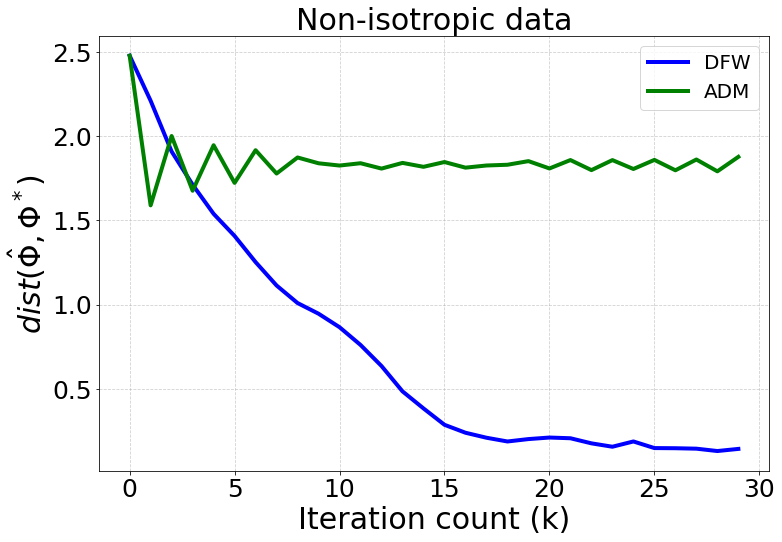

In [39]:
# Create a plot to show the convergence of the Gibbs Sampler (Log-joint vs iterations)
fig, ax = plt.subplots(figsize=(12,8))


# Plot the data
ax.plot(list(range(int(K))), Error_FW, label=r'DFW', color='blue', linestyle='-', linewidth=4)
ax.plot(list(range(int(K))), Error_WFW, label=r'ADM',  color='green', linestyle='-', linewidth=4)

# Set labels and a title
ax.set_xlabel('Iteration count (k)',fontsize=30)
ax.set_ylabel(r'$dist(\hat{\Phi},\Phi^*)$',fontsize=30)
ax.tick_params(axis='both', labelsize=25)
ax.set_title(r'Non-isotropic data',fontsize=30)
plt.legend()
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[:2]  
labels = labels[:2] 
plt.legend(handles=handles, labels=labels,fontsize=20)

# Customize the grid
ax.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()